In [1]:
import os as os
import numpy as np
import random

In [2]:
os.chdir("../")

In [3]:
from parser_FAR_dvf import *
from tm_utils import load_machine_from_db, pptm
import tqdm

In [4]:
PATH_TO_DVF = "resources/dfa_nfa_proofs.dvf"
PATH_TO_DB = "../all_5_states_undecided_machines_with_global_header"

In [5]:
dvf = FAR_DVF.from_file(PATH_TO_DVF)

In [26]:
random_entries = np.random.randint(0,dvf.n_entries-1,1000)

In [50]:
for i_entry in tqdm.tqdm(random_entries):

    with open(PATH_TO_DVF, "rb") as dvf_file:
        header, entry = dvf.ith_entry(dvf_file, i_entry)

    with open(PATH_TO_DB, "rb") as db_file:
        machine = load_machine_from_db(db_file,header.machine_id) 

    R = np.zeros((2,entry.nb_nfa_states,entry.nb_nfa_states)).astype(bool)

    # Equation 4'
    R[0,-1,-1] = True
    R[1,-1,-1] = True

    # Machine dependent static equations
    for from_state in range(5):
            for read_symbol in range(2):
                write, move_to, goto = machine[
                    6 * from_state + 3 * read_symbol : 6 * from_state + 3 * read_symbol + 3
                ]
                goto -= 1

                # Symmetrising machine if scan is right to left
                if entry.direction_right_to_left:
                    move_to = 1 - move_to

                # Equation 5'
                if goto == -1:
                    R[read_symbol][:-1,][from_state::5, :][:, -1] = True

                # Equation 7'
                elif move_to == 0:
                    for i_dfa_state in range(entry.nb_dfa_states):
                        goes_to_dfa_state = entry.dfa_transitions[i_dfa_state][write]
                        nfa_state_i_f = 5 * i_dfa_state + from_state
                        nfa_state_delta_i_w_t = 5 * goes_to_dfa_state + goto
                        R[read_symbol][nfa_state_i_f, nfa_state_delta_i_w_t] = True
                        
                        
    # Machine dependent dynamic equations
    old_R = None
    while old_R is None or (old_R != R).any():
        old_R = np.copy(R)

        for from_state in range(5):
            for read_symbol in range(2):
                write, move_to, goto = machine[
                    6 * from_state + 3 * read_symbol : 6 * from_state + 3 * read_symbol + 3
                ]
                goto -= 1

                if goto == -1:
                    continue

                # Symmetrising machine if scan is right to left
                if entry.direction_right_to_left:
                    move_to = 1 - move_to

                # Equations 6' left move, iterative construction
                if move_to == 1:
                    for b in range(2):
                        RbRw = old_R[b] @ old_R[write]
                        for i_dfa_state in range(entry.nb_dfa_states):
                            goes_to_dfa_state = entry.dfa_transitions[i_dfa_state][b]

                            i = 5 * goes_to_dfa_state + from_state
                            j = 5 * i_dfa_state + goto

                            R[read_symbol][i, :] += RbRw[j, :]
    
    stop = False
    for i in range(2):
        if (R[i] != entry.nfa_transitions[i]).any():
            print(f"Error on R{i}")
            print((R[i] != entry.nfa_transitions[i]).astype(int))
            stop = True
            break
            
    # Solve a
    a = np.zeros((1,entry.nb_nfa_states)).astype(bool)
    a[0,-1] = True
    
    old_a = None
    while old_a is None or (a != old_a).any():
        old_a = np.copy(a)
        a = (R[0] @ old_a.T).T
    
    e_0 = np.zeros((1,entry.nb_nfa_states)).astype(bool)
    e_0[0,0] = True

    assert(not (e_0 @ a.T)[0,0])
            
    if stop:
        break

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 305.57it/s]


In [40]:
a = np.zeros((1,entry.nb_nfa_states)).astype(bool)
a[0,-1] = True

In [41]:
a

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True]])

In [44]:
a @ a.T

array([[ True]])

In [34]:
with open(PATH_TO_DVF, "rb") as dvf_file:
    header, entry = dvf.ith_entry(dvf_file, 77)

with open(PATH_TO_DB, "rb") as db_file:
    machine = load_machine_from_db(db_file,header.machine_id) 

R = np.zeros((2,entry.nb_nfa_states,entry.nb_nfa_states)).astype(bool)

# Equation 4'
R[0,-1,-1] = True
R[1,-1,-1] = True

# Machine dependent static equations
for from_state in range(5):
    for read_symbol in range(2):
        write, move_to, goto = machine[
            6 * from_state + 3 * read_symbol : 6 * from_state + 3 * read_symbol + 3
        ]
        goto -= 1

        # Symmetrising machine if scan is right to left
        if entry.direction_right_to_left:
            move_to = 1 - move_to

        # Equation 5'
        if goto == -1:
            R[read_symbol][:-1,][from_state::5, :][:, -1] = True

        # Eaquation 7'
        elif move_to == 0:
            for i_dfa_state in range(entry.nb_dfa_states):
                goes_to_dfa_state = entry.dfa_transitions[i_dfa_state][write]
                nfa_state_i_f = 5 * i_dfa_state + from_state
                nfa_state_delta_i_w_t = 5 * goes_to_dfa_state + goto
                R[read_symbol][nfa_state_i_f, nfa_state_delta_i_w_t] = True

for i in range(2):
    assert((R[i] <= entry.nfa_transitions[i]).all())

# Machine dependent dynamic equations
old_R = None
while old_R is None or (old_R != R).any():
    old_R = np.copy(R)
    
    for from_state in range(5):
        for read_symbol in range(2):
            write, move_to, goto = machine[
                6 * from_state + 3 * read_symbol : 6 * from_state + 3 * read_symbol + 3
            ]
            goto -= 1

            if goto == -1:
                continue
            
            # Symmetrising machine if scan is right to left
            if entry.direction_right_to_left:
                move_to = 1 - move_to

            # Equations 6' left move, iterative construction
            if move_to == 1:
                for b in range(2):
                    RbRw = old_R[b] @ old_R[write]
                    for i_dfa_state in range(entry.nb_dfa_states):
                        goes_to_dfa_state = entry.dfa_transitions[i_dfa_state][b]

                        i = 5 * goes_to_dfa_state + from_state
                        j = 5 * i_dfa_state + goto

                        R[read_symbol][i, :] += RbRw[j, :]
                        
assert((R[0] <= entry.nfa_transitions[0]).all())
assert((R[1] <= entry.nfa_transitions[1]).all())

In [17]:
print(R[1].astype(int))
print()
print(entry.nfa_transitions[1].astype(int))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 

In [106]:
for i in range(2):
    print((R[i] <= entry.nfa_transitions[i]).all())

True
False


In [62]:
R[1].astype(int)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

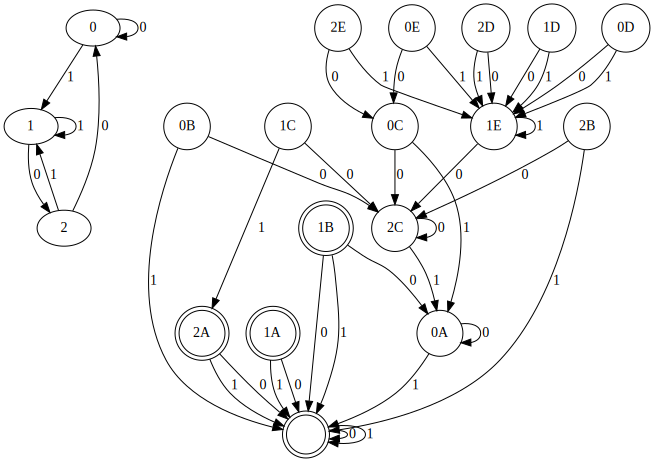

In [12]:
entry.to_graphviz()

In [51]:
def unflatten_DFA(flat_DFA):
    unflatten_DFA: list[list[int]] = []
    for i, s in enumerate(flat_DFA):
        if i % 2 == 0:
            unflatten_DFA.append([])
        unflatten_DFA[-1].append(s)
    return unflatten_DFA

In [53]:
unflatten_DFA([0,1,2,3])

[[0, 1], [2, 3]]